In [34]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import date, datetime, time, timedelta
from scipy import stats 

sns.set()
%matplotlib inline

'''$$$$$$$$$$$$$$$$$$$$ Start importing data and EDA $$$$$$$$$$$$$$$$$$$$'''
def general_explore_file(filepath, show = False):
    df = pd.read_csv(filepath)
    if show:
        explore_df(df)
    return df

def get_prep_data(filepath, parse_dt = ['Opened', 'Closed'], fix_index = 'CaseID'):
    df = pd.read_csv(filepath, parse_dates =parse_dt, infer_datetime_format=True)
    if fix_index:
        df.set_index(fix_index, inplace = True)
    return df
    
def read_csv_chunks_into_df(file_path, chunk_size, parse_date=False):    
    if parse_date:
        chunks = pd.read_csv(file_path, parse_dates= ['Opened','Closed','Updated'], \
                             infer_datetime_format=True, chunksize = chunk_size )
    else:
        chunks = pd.read_csv(file_path, chunksize = chunk_size )
    df = pd.concat(chunks) 
    return df

def explore_df(df):
    print '*********** Shape of df **************'
    print df.shape
    features = df.columns.values    
    print '********** Number of features ***************'
    print len(features) 
    print '********** Features ***************'
    print features
    print '******* Head of df ******************'
    print df.head()
    print '******* Info of df ******************'
    print df.info()
    print '******** Description of df *****************'
    print df.describe()
    return

def import_data(folder, filename):
    '''import the data and set the right datetime '''
    folder = folder
    filename_original = filename
    filepath = folder + filename_original
    df = general_explore_file(filepath)

    df = df.sort_values('CaseID')
    df.set_index('CaseID', inplace = True)

    ''' parse dates'''
    dt_list = ['Opened','Closed','Updated'] # list of datetime columns
    time_format = '%m/%d/%Y %I:%M:%S %p'
    dft = parsedate(df, dt_list, time_format) # parse ['Opened','Closed','Updated'] to timedate 
    return dft
    
def get_unique(df):
    features = df.columns.values
    print '********* Number of unique values **********'
    for feature in features:
        print feature,' ', len(df[feature].unique())
    return 

def get_missing(df):
    print '********* Number of missing values **********'
    df2 = df.isnull()
    features = df.columns.values
    for feature in features:
        temp = df[df2[feature]]
        print feature,' ', len(temp)

def drop_na_row(df,feature):
    df = df.ix[df[feature].notnull(), :]
    return df

def get_value_counts(df, feature_list):
    for feature in feature_list:
        print '************ '+feature+' value counts ***********'
        print df[feature].value_counts(dropna = False)
    return

def parsedate(df, columns, time_format):
    for column in columns:
        df[column] = pd.to_datetime(df[column], format = time_format)
    return df

def days_to_minutes(dt):
    return  dt.total_seconds()//60#(td.seconds//60)%60

def days_to_hours(dt):
    hours = dt.total_seconds()/3600#(td.seconds//60)%60
    return np.round(hours,1)

def get_sorted_category_value(df, category):
    ''' returns sorted categorical values based on the mean process_hours '''
    df1 = df.copy()
    dfm = df1.groupby(category).mean()
    dfm = dfm.sort_values('Process_days')
    return dfm.index

def category_to_numer_dict(df, category, values):
    '''
    Change a categorical column to numeric and save the categorical values in a 
    dictionary for later reference values is sorted list of categorical values
    '''
    dict = defaultdict(str)
    for i,value in enumerate(values):
        dict[i] = value # store the categorical values in a dictionary for reference
        df.ix[df[category]==value, category] = i
    df[category].astype(int, inplace=True)
    return dict

def category_to_numer_basic(df, category):
    '''Change a categorical column to numeric and save the categorical 
    values in a dictionary for later reference (basic version)'''
    values = df[category].unique()
    for i,value in enumerator(values):
        df.ix[df[category]==value, category] = i
    df[category].astype(int, inplace=True)
    return df

def batch_process_categories(df, categories):
    '''convert categorical features to numerical by batch, 
    return a dictionary of dictionaries storing the mapping of categorical value to number'''
    cate_dict = {}
    for category in categories:
        '''Convert the categoricl column to numerical'''
        if  category in df.columns.values:
            cate_val = get_sorted_category_value(df,category) 
            '''The category_to_numer_dict() modify the input dataframe by side-effect and return a dictionary'''
            cate_dict[category] = category_to_numer_dict(df, category, cate_val)
    return cate_dict

def check_group_mean(df, groupby_cols, target_cols):
    for col in groupby_cols:
        dfm = df.groupby(col).mean()
        print dfm[target_cols]
    return

def check_group_stats(df, groupby_cols, target_cols):
    for col in groupby_cols:
        dfm = df.groupby(col).describe()
        print dfm[target_cols]
    return

'''$$$$$$$$$$$$$$$$$$$$ End importing data $$$$$$$$$$$$$$$$$$$$'''
def clean_data(dft):
    '''remove and save the cases that are not closed'''
    dft_still_open = dft[dft['Closed'].isnull()] # cases that not closed
    filename_open = 'SF311_still_open_raw.csv'
    dft_still_open_csv_path = folder + filename_open
    dft_still_open.to_csv(dft_still_open_csv_path) # dft_still_open.csv contains cases that not closed

    '''calculate the process time '''
    condition = dft['Closed'].notnull()
    dft_closed = dft[condition] # cases that are closed 
    dft_closed['Process_days'] = dft_closed['Closed'] - dft_closed['Opened']
    dft_closed['Process_hours'] = dft_closed['Process_days'].apply(days_to_hours)

    ''' remove cases with process time <= 0 hours and save theses cases '''
    dft_wrong_dates = dft_closed[dft_closed['Process_hours'] <= 0]
    filename_wrong_dates = 'SF311_wrong_dates_raw.csv'
    dft_wrong_dates_csv_path = folder + filename_wrong_dates
    dft_wrong_dates.to_csv(dft_wrong_dates_csv_path) 
    # dft_wrong_dates_raw.csv contains cases that have wrong dates: closed before opened'''re
    dft_right_dates = dft_closed[dft_closed['Process_hours'] > 0]

    ''' remove duplicated cases and save theses cases '''
    dft_duplicates, dft_valid = check_word_in_col(dft_right_dates, 'Status Notes', 'Duplicate')
    filename_duplicates = 'SF311_duplicates_raw.csv'
    dft_duplicates_csv_path = folder + filename_duplicates
    dft_duplicates.to_csv(dft_duplicates_csv_path) # dft_duplicates_raw.csv contains cases that are duplicated
    
    '''convert Process_days to float'''
    dft_valid['Process_days'] = dft_valid['Process_hours']/24.0
    
    '''save raw valid cases'''
    filename_valid = 'SF311_valid_raw.csv'
    dft_valid_csv_path = folder + filename_valid
    dft_valid.to_csv(dft_valid_csv_path)
    
    '''remove unnecessary columns and save the cases to csv file'''
    drop_col = ['Updated','Status', 'Media URL']
    dft_valid_reduced = dft_valid.drop(drop_col, axis =1)
    filename_reduced = 'SF311_valid_reduced.csv'
    dft_valid_reduced_csv_path = folder + filename_reduced
    dft_valid_reduced.to_csv(dft_valid_reduced_csv_path)
    
    print 'Number of original cases: ', len(dft)
    print 'Cases that are not closed: ', len(dft_still_open)
    print 'Cases with process time <= 0: ', len(dft_wrong_dates)
    print 'Cases with process time > 0: ', len(dft_right_dates)
    print 'Duplicated cases: ', len(dft_duplicates)
    print 'Valid cases: ', len(dft_valid)
    return dft_valid_reduced


def plot_data_on_date(df, data_col, year = False, month = False, day = False, dot = True):
    ''' set index to date and plot df column data against the index, year can be Boolean or int'''
    dfcp = df.copy()
    dfcp.set_index('Opened', inplace = True)
    if (type(year)==int) & (type(month)==int) & (type(day)==int):
        cond1 = dfcp.index.year == year
        cond2 = dfcp.index.month == month
        cond3 = dfcp.index.day == day
        dfcp1 = dfcp[cond1 & cond2 & cond3]           
    elif (type(year)==int) & (type(month)==int):
        cond1 = dfcp.index.year == year
        cond2 = dfcp.index.month == month
        dfcp1 = dfcp[cond1 & cond2]        
    elif type(year)==int:
        dfcp1 = dfcp[dfcp.index.year == year]
    else:
        dfcp1 = dfcp
    if dot:     
        dfcp1[data_col].plot(figsize=(18,16), c='m', alpha = 0.2,style='o')
    else:
        dfcp1[data_col].plot(figsize=(18,16), c='k', alpha = 0.2)
    plt.show()
    return

'''This function is not necessary, becasue plot_data_on_date() can do scatter plot'''
'''plot a scatter plot on data'''
def scatter_data_on_date(df, data_col, year = False, month = False, day = False):
    ''' set index to date and plot df column data against the index; year, month, and day can be Boolean or int'''
    dfcp = df.copy()
    dfcp['Opened_Int'] = dfcp['Opened'].astype(np.int64)
    dfcp.set_index('Opened', inplace = True)
    if (type(year)==int) & (type(month)==int) & (type(day)==int):
        cond1 = dfcp.index.year == year
        cond2 = dfcp.index.month == month
        cond3 = dfcp.index.day == day
        dfcp1 = dfcp[cond1 & cond2 & cond3]                   
    elif (type(year)==int) & (type(month)==int):
        cond1 = dfcp.index.year == year
        cond2 = dfcp.index.month == month
        dfcp1 = dfcp[cond1 & cond2]        
    elif type(year)==int:
        dfcp1 = dfcp[dfcp.index.year == year]        
    else:
        dfcp1 = dfcp
    dfcp1.plot(kind = 'scatter', x='Opened_Int', y='Process_days', alpha = 0.2, c = 'm', figsize=(20,10))  
    return


'''######## this can be a short lambda expression########'''
def get_str_list(string):
    '''convert to a list of string'''
    return str(string).split()

'''######## this can be a short lambda expression########'''
def check_dup(str_list):
    '''check if word 'Duplicate' is in the string list'''
    return 'Duplicate' in str_list

def check_word_in_col(df, column, word):
    '''check if a word in the column, returns a tuple of dataframes, 
    the first one contains the word and second one does not''' 
    df1 = df.copy()
    get_str_list = lambda x: str(x).split()
    check_dup = lambda x: word in x

    df1[column+'1'] = df1[column].apply(get_str_list) # turn df1[column] into a list of strings
    cond = df1[column+'1'].apply(check_dup) # check if df1[column+'1'] contains the word
    df_found = df[cond]
    df_not_found = df[~cond]
    return df_found, df_not_found

def add_features(df):
    df1 = df.copy()
    '''Add features: Day of week, Month, Year, Weekend '''
    df1['Day_Of_Week'] = df1['Opened'].dt.dayofweek
    df1['Month'] = df1['Opened'].dt.month
    df1['Year'] = df1['Opened'].dt.year
    
    df1['Weekend'] = (df1['Day_Of_Week'].isin((5,6))).astype(int) # if the open day is at weekend
    '''Add feature Holiday and Before_Holiday'''
    df1['Opened_Int'] = df1['Opened'].astype(np.int64)
    
    cal = calendar()
    holidays = cal.holidays()
    df1['Holiday'] = ((df1['Opened'].dt.date).astype('datetime64').isin(holidays)).astype(int)
    df1['Before_Holiday'] = (((df1['Opened'].dt.date).astype('datetime64')+timedelta(days = 1))\
                             .isin(holidays)).astype(int)
    num_of_holiday = len(df1[df1['Holiday'] == 1])
    num_of_before_holiday = len(df1[df1['Before_Holiday'] == 1])
    return df1

def get_oneway_anova(df, target_col, group_col, group_list=False):
    if group_list:
        groups = group_list
    else:
        groups = list(df[group_col].unique())
    datasets =[]
    for component in groups:
        df_temp = df[df[group_col] == component]
        datasets.append(np.array(df_temp[target_col]))
    f_val, p_val = stats.f_oneway(*datasets)  
    print "One-way ANOVA P =", p_val  
    return p_val

def add_current_open(df):
    '''add column Current_Open which has the number of current open cases'''
    def get_open_cases(opt):
        condition1 = df['Opened'] < opt
        condition2 = df['Closed'] > opt
        open_cases = df[condition1 & condition2]
        return len(open_cases)
    df['Current_Open'] = df['Opened'].apply(get_open_cases)
    return df

def create_pilot(df, folder, filename):    
    '''Create a pilot dataset of most recent 100000 cases for preliminary 
    modeling and feature engineering, save as SF311_pilot.csv '''
    pilot = df.iloc[:100000,:]
    pilot.to_csv(folder+filename_pilot)
    return

def impute_neighbor_knn():
    pass

def creat_data_chunk(df, folder, filename, days = 730):
    if timedelta(days = days) > df['Opened'].max()-df['Opened'].min():
        print 'Error! Days over the limit!'
        return
    '''get the date that is 2 year before the data collecting date'''
    new_end_date = df['Opened'].max() - timedelta(days = days)     
    condition1 = df['Opened'] <= new_end_date
    condition2 = df['Process_days'] <= days
    df_chunk = df[condition1 & condition2]
    df_chunk.to_csv(folder+filename)
    return

Data cleaning and modeling procedure:

5. Deal with missing data. Be sure not to us any information gloabally to impute missing value at this stage, because before the test-train split, using gloabal information to impute missing values leads to a data leakage!
********* Number of missing values **********
Status Notes   648795
Request Type   13352
Request Details   70431
Address   11
Supervisor District   8945
Neighborhood   123235
Point   66545
**********************************************
There are 7 features with missing data that may have impact on modeling.
The initial strategy for Request Type is to copy the Request Details to Request Type. But only 7 values can be copied because 13345 out of 13352 cases they are both missing. Decide to add 'Missing' as Request Type.

Strategy for Neighborhood is to use KNN and valid Point to impute the missing values.
Strategy for Supervisor District is to find the Neighborhood or Point, and use KNN to impute missing value; another simpler strategy is to impute -1, which is already used in the dataset.
Strategy for Address is to add 'Missing' as address; there are only 11 records missing; also may not use address in initial modeling.
Have no strategy for Point and Status Notes because will not use Point and Status Notes for modeling.

5.1. Deal with missing Request type and details. 
both request type and details are missing:  13345
only request type not details is missing:  7
only request details but not type is missing:  57086

Three steps:
A. Copy Request Details to missing Request Type and fill 7 missing values.

B. Fill missing Request Type with 'Mssing'.

C. Copy Request Types to missing Request Details.

5.2. Save filled df to csv file named SF311_fill.csv

5.3. Plan to use KNN for imputing the neighborhood, but before doing it I need to split the dataset into train-valid and test set, because KNN will use information from the whole dataset, lead to a data leakage.
Right now, for building the initial model, I will simply impute missing Supervisor District as -1.0, and missing Neighborhood as 'MissingNeighborhood'.

5.4. Save dataset with missing values filled to csv file named 'SF311_fill.csv'.

6. Train_test split and save the file.

6.1. Generate a 80-20% train-test split of filled dataframe, save them to csv file. The purpose of this split is not to create the X_train, X_test, y_train, y_test datasets. It just split the dataset to train and test. Will use train for further split into training and valisdation datasets with X and y seperated.

6.2. Save generated dataframes to 'SF311_train.csv' and 'SF311_test.csv'

7. Premodeling process.

7.1. Reduced the dataframe by select the useful columns, including the target column and other useful features: 'Responsible Agency', 'Category', 'Request Type', 'Supervisor District', 'Neighborhood', 'Source', 'Process_days',  'Day_Of_Week', 'Month', 'Year', 'Weekend', 'Holiday', 'Before_Holiday', 'Opened_Int'.

7.2. Scale Opened_Int variable: dividing it by 10^16.

7.3. Convert categorical features to numerical variables, including 'Category','Responsible Agency','Request Type','Neighborhood','Source'.

7.4. Split the training dataframe to training and validation sets (ratio 7:3), yielding dataframes and series of X_train, X_test, y_train, y_test ready for modeling.

8. Modeling and cross-validation. 

8.1. Simple model using mean of y_train for predicted value. Get Mean_square_error(MSE) of mean_model: 17439.1.

8.2. Linear regression model. Get r_square: 0.137817479254; MSE: 15035.52; Conclusion: linear regression is not a good model for the dataset.

8.3. RandomForest regressor model. RandomForestRegressor with n_estimators=100 get r_square: 0.5544, oob_score: 0.539 and MSE: 7770.96.

Get the rank of feature importance based on the preliminary random forest model. The top 6 features from high to low: Open_time, Request type, Resposible agency, Neighborhood, District, Category.

8.4. Gradient boosting Regressor model. Runed with three configirations:
GradientBoostingRegressor: n_estimators=100, learning_rate=0.1
r_square:  0.4041, MSE:  10391.96

GradientBoostingRegressor: n_estimators=300, learning_rate=0.1
r_square:  0.4493 MSE:  9604.32

GradientBoostingRegressor: n_estimators=600, learning_rate=0.1
r_square:  0.4785, MSE:  9094.79

Get the rank of feature importance based on the preliminary Gradient boosting model. Get the save results as top 6 features: Open_time, Request type, Resposible agency, Neighborhood, District, Category.

In [2]:
'''
*****************************************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
*****************************************************************
'''
'''Deal with missing values'''
'''Read data from new engineered csv file'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/'
filename_engineered = 'SF311_engineered.csv'

df = get_prep_data(folder+filename_engineered)
df_cp = df.copy()

print 'Engineered dataframe info: ', df.info()
df.head(2)

Engineered dataframe info: <class 'pandas.core.frame.DataFrame'>
Int64Index: 1935020 entries, 185580 to 6909895
Data columns (total 21 columns):
Opened                 datetime64[ns]
Closed                 datetime64[ns]
Status Notes           object
Responsible Agency     object
Category               object
Request Type           object
Request Details        object
Address                object
Supervisor District    float64
Neighborhood           object
Point                  object
Source                 object
Process_days           float64
Process_hours          float64
Day_Of_Week            int64
Month                  int64
Year                   int64
Weekend                int64
Holiday                int64
Before_Holiday         int64
Opened_Int             int64
dtypes: datetime64[ns](2), float64(3), int64(7), object(9)
memory usage: 324.8+ MB
 None


,Opened,Closed,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,...,Source,Process_days,Process_hours,Day_Of_Week,Month,Year,Weekend,Holiday,Before_Holiday,Opened_Int
CaseID,,,,,,,,,,,,,,,,,,,,,
185580,2008-03-20 11:48:32,2013-03-26 18:13:25,Case Completed - resolved:,DPW Ops Queue,Tree Maintenance,Trees - Damaging_Property,Lifted_sidewalk_tree_roots,Intersection of FILLMORE ST and TURK ST,5.0,Western Addition,...,Voice In,1832.266667,43974.4,3,3,2008,0,0,0,1206013712000000000
196699,2008-04-13 14:04:28,2015-06-11 12:00:00,Case Completed - resolved: Request closed by ...,DPW Ops Queue,Tree Maintenance,Trees - Damaging_Property,Lifted_sidewalk_tree_roots,"479 GOLD MINE DR, SAN FRANCISCO, CA, 94131",8.0,Diamond Heights,...,Voice In,2614.912500,62757.9,6,4,2008,1,0,0,1208095468000000000


In [ ]:
get_missing(df)
print len(df)

In [5]:
'''there are 6 features with missing data that may have impact on modeling'''
'''strategy for Neighborhood is to find the point or address and then deduct the neighborhood'''
cond1 = df['Neighborhood'].isnull()
'''strategy for Supervisor District is to find the Neighborhood, point or address and deduct the District'''
'''another simpler strategy is to impute -1. for missing as already in the dataset'''
cond2 = df['Supervisor District'].isnull()
'''strategy for Address is to find the point and deduct the Address, only 11 records are missing'''
'''may not use address in initial modeling'''
cond3 = df['Address'].isnull()
'''no strategy for Point, because will not use point for modeling'''
cond4 = df['Point'].isnull()
'''the initial strategy for Request Type is to copy the Request Details to Request Type, but failed 
because 13345 out of 13352 cases, they are both missing'''
'''add missing as Request Type'''
cond5 = df['Request Type'].isnull()
'''no strategy for Point, because will not use Request Details for modeling'''
cond6 = df['Request Details'].isnull()

In [9]:
'''First, deal with request type and detail'''
miss_type_detail_index = df[cond5 & cond6].index[:10] # both request type and details are missing 
miss_type_index = df[cond5 & (~cond6)].index
miss_detail_index = df[(~cond5) & cond6].index

#print df[df.index.isin(miss_type_index)] # only request type not details is missing 

print 'both request type and details are missing: ', len(df[cond5 & cond6])
print 'only request type not details is missing: ', len(df[cond5 & (~cond6)])
print 'only request details but not type is missing: ', len(df[ (~cond5) & cond6])

'''1. copy Request Details to missing Request Type and fill 7 missing values'''
df['Request Type'].fillna(df['Request Details'], inplace = True)
'''only request type not details is missing, should be filled'''
#print df[df.index.isin(miss_type_index)] 

'''2. fill missing Request Type with 'Mssing'''
df['Request Type'].fillna('Missing', inplace = True)
'''both request type and details are missing, should be filled with Missing'''
#print df[df.index.isin(miss_type_detail_index)] 

'''3. copy Request Types to missing Request Details'''
df['Request Details'].fillna(df['Request Type'], inplace = True)

print 'both request type and details are missing: ', \
len(df[df['Request Type'].isnull() & df['Request Type'].isnull()])
print 'request type is missing: ', len(df[df['Request Type'].isnull()])
print 'request details is missing: ', len(df[df['Request Details'].isnull()])
#print df[df.index.isin(miss_type_detail_index)]

both request type and details are missing:  13345
only request type not details is missing:  7
only request details but not type is missing:  57086
both request type and details are missing:  0
request type is missing:  0
request details is missing:  0


In [13]:
'''Second, deal with Supervisor District and Neighborhood'''
'''Simply fill in -1.0 for Supervisor District and MissingNeighborhood for Neighborhood'''
'''The purpose is to build a simple model and will revisit the missing data to improve the model'''
print 'Supervisor District is missing: ', len(df[cond2])
print 'Neighborhood is missing: ', len(df[cond1])

miss_neighbor_index = df[cond1].index[:10]
df['Supervisor District'].fillna(-1.0, inplace = True)
df['Neighborhood'].fillna('MissingNeighborhood', inplace = True)

print 'Supervisor District is missing: ', len(df[df['Supervisor District'].isnull()])
print 'Neighborhood is missing: ', len(df[df['Neighborhood'].isnull()])
#df[df.index.isin(miss_neighbor_index)]

Supervisor District is missing:  8945
Neighborhood is missing:  123235
Supervisor District is missing:  0
Neighborhood is missing:  0


In [14]:
'''write the data with missing value being filled to csv named SF311_fill.csv'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/'
filename_fill = 'SF311_fill.csv'
df.to_csv(folder+filename_fill)

In [ ]:
get_missing(df)
'''Finish filling in missing data'''
'''
*****************************************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
*****************************************************************
'''

In [17]:
'''Train_test split and save the file'''
'''Read data from new filled csv file'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/'
filename_fill = 'SF311_fill.csv'

df_fill = get_prep_data(folder+filename_fill)

In [78]:
'''Will use KNN to impute the neighborhood, but before doing it need to split the data into train-valid and test set'''
'''Because KNN will use information from the whole dataset, lead to a data leakage'''
'''Do a 80-20% train-test split on dataframe'''
# np.random.seed(seed = 111)
# df_fill['Flag'] = np.random.random(size = len(df_fill)) >=0.8
# df_train = df_fill[~df_fill['Flag']]
# df_test = df_fill[df_fill['Flag']]

def train_test_df_split(df, test_size = 0.2, ramdom_seed = 111):
    np.random.seed(seed = ramdom_seed)
    df['Flag'] = np.random.random(size = len(df)) <= test_size
    df_train = df[~df['Flag']]
    df_test = df[df['Flag']]
    df_train.drop('Flag', axis=1, inplace = True)
    df_test.drop('Flag', axis=1, inplace = True)
    return df_train, df_test

In [21]:
df_train, df_test = train_test_df_split(df_fill, test_size = 0.2, ramdom_seed = 111 )
print len(df_train), len(df_test), len(df_test)*1./len(df), len(df_train)+ len(df_test)

1549243 385777 0.199365898027 1935020


In [22]:
'''write the train and test datasets to csv'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/'
filename_train = 'SF311_train.csv'
filename_test = 'SF311_test.csv'
df_train.to_csv(folder+filename_train)
df_test.to_csv(folder+filename_test)
'''Finish train_test split'''
'''
*****************************************************************
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
*****************************************************************
'''

In [2]:
'''$$$$$$$$$$$$$$$ Usually can start here: $$$$$$$$$$$$$$$$$$$$$'''

'''Read data from new train and test csv file'''
folder = '/Users/haowei/Documents/GN/Capstone/Capstone-project/Data/'
filename_train = 'SF311_train.csv'
filename_test = 'SF311_test.csv'

df_tr = get_prep_data(folder+filename_train)
#df_te = get_prep_data(folder+filename_test)
print len(df_tr), #len(df_te)
'''df_te will not be used untill all modeling is finished'''

1549243

'df_te will not be used untill all modeling is finished'

In [5]:
df_trcp = df_tr.copy()

In [35]:
'''select the useful feature columns'''
df_trcp = df_tr.copy()
use_features = ['Responsible Agency', 'Category', 'Request Type',\
                'Supervisor District', 'Neighborhood', 'Source', 'Process_days', \
                'Day_Of_Week', 'Month', 'Year', 'Weekend', 'Holiday', 'Before_Holiday', 'Opened_Int']
df_tr = df_tr[use_features]
print df_tr.info()
df_tr.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549243 entries, 185580 to 6909895
Data columns (total 14 columns):
Responsible Agency     1549243 non-null object
Category               1549243 non-null object
Request Type           1549243 non-null object
Supervisor District    1549243 non-null float64
Neighborhood           1549243 non-null object
Source                 1549243 non-null object
Process_days           1549243 non-null float64
Day_Of_Week            1549243 non-null int64
Month                  1549243 non-null int64
Year                   1549243 non-null int64
Weekend                1549243 non-null int64
Holiday                1549243 non-null int64
Before_Holiday         1549243 non-null int64
Opened_Int             1549243 non-null float64
dtypes: float64(3), int64(6), object(5)
memory usage: 177.3+ MB
None


,Responsible Agency,Category,Request Type,Supervisor District,Neighborhood,Source,Process_days,Day_Of_Week,Month,Year,Weekend,Holiday,Before_Holiday,Opened_Int
CaseID,,,,,,,,,,,,,,
185580,124,23,1209,5.0,86,4,1832.266667,3,3,2008,0,0,0,120.601371
196699,124,23,1209,8.0,109,4,2614.912500,6,4,2008,1,0,0,120.809547


In [7]:
'''scale feature Opened_Int'''
df_tr['Opened_Int'] = df_tr['Opened_Int']*1./10**16
df_tr.head()

,Responsible Agency,Category,Request Type,Supervisor District,Neighborhood,Source,Process_days,Day_Of_Week,Month,Year,Weekend,Holiday,Before_Holiday,Opened_Int
CaseID,,,,,,,,,,,,,,
185580,DPW Ops Queue,Tree Maintenance,Trees - Damaging_Property,5.0,Western Addition,Voice In,1832.266667,3,3,2008,0,0,0,120.601371
196699,DPW Ops Queue,Tree Maintenance,Trees - Damaging_Property,8.0,Diamond Heights,Voice In,2614.912500,6,4,2008,1,0,0,120.809547
208668,DPW Ops Queue,Tree Maintenance,Trees - Damaging_Property,11.0,Mission Terrace,Voice In,2959.691667,6,5,2008,1,0,0,120.989377
214411,DPW Ops Queue,Tree Maintenance,Trees - Damaging_Property,9.0,Mission,Voice In,2948.650000,2,5,2008,0,0,0,121.076332
240216,DPW Ops Queue,Street and Sidewalk Cleaning,Illegal_Dumping,4.0,Inner Sunset,Voice In,0.237500,1,7,2008,0,0,0,121.487196


In [36]:
'''convert categorical features to numerical'''
cate_list = ['Category','Responsible Agency','Request Type','Neighborhood','Source']
cate_dict = batch_process_categories(df_tr, cate_list)
print df_tr.info()
cate_dict['Category'][23]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549243 entries, 185580 to 6909895
Data columns (total 14 columns):
Responsible Agency     1549243 non-null object
Category               1549243 non-null object
Request Type           1549243 non-null object
Supervisor District    1549243 non-null float64
Neighborhood           1549243 non-null object
Source                 1549243 non-null object
Process_days           1549243 non-null float64
Day_Of_Week            1549243 non-null int64
Month                  1549243 non-null int64
Year                   1549243 non-null int64
Weekend                1549243 non-null int64
Holiday                1549243 non-null int64
Before_Holiday         1549243 non-null int64
Opened_Int             1549243 non-null float64
dtypes: float64(3), int64(6), object(5)
memory usage: 177.3+ MB
None


23

In [76]:
df_tr.head(2)

,Responsible Agency,Category,Request Type,Supervisor District,Neighborhood,Source,Process_days,Day_Of_Week,Month,Year,Weekend,Holiday,Before_Holiday,Opened_Int
CaseID,,,,,,,,,,,,,,
185580,124,23,1209,5.0,86,4,1832.266667,3,3,2008,0,0,0,120.601371
196699,124,23,1209,8.0,109,4,2614.912500,6,4,2008,1,0,0,120.809547


In [9]:
'''use the training dataset and do another training validation split'''
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

'''Setup data with simple train/test split'''
def train_vali_split(df, target_col, test_size = 0.3, random_seed = 100):
    v_features = df.columns.tolist()
    v_features = v_features[:]
    del v_features[v_features.index(target_col)]

    X = df.ix[:, v_features]
    y = df[target_col].astype('float')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    return X_train, X_test, y_train, y_test

/Users/haowei/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/haowei/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
# df_tra, df_vali = tr_te_split(df_tr, ramdom_seed = 100)
# print len(df_tra), len(df_vali), len(df_vali)*1./len(df_tr), len(df_tra)+ len(df_vali), len(df_tr)
X_train, X_test, y_train, y_test = train_vali_split(df_tr, 'Process_days', test_size = 0.3, random_seed = 100)

In [13]:
print len(X_train), len(X_test), len(y_train), len(y_test)
print X_train.info()
print y_train.describe()

1084470 464773 1084470 464773
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1084470 entries, 3876037 to 5173837
Data columns (total 13 columns):
Responsible Agency     1084470 non-null object
Category               1084470 non-null object
Request Type           1084470 non-null object
Supervisor District    1084470 non-null float64
Neighborhood           1084470 non-null object
Source                 1084470 non-null object
Day_Of_Week            1084470 non-null int64
Month                  1084470 non-null int64
Year                   1084470 non-null int64
Weekend                1084470 non-null int64
Holiday                1084470 non-null int64
Before_Holiday         1084470 non-null int64
Opened_Int             1084470 non-null float64
dtypes: float64(2), int64(6), object(5)
memory usage: 115.8+ MB
None
count    1.084470e+06
mean     3.324520e+01
std      1.309751e+02
min      4.166667e-03
25%      6.416667e-01
50%      2.695833e+00
75%      9.875000e+00
max      2.959692e+03

In [ ]:
'''confirm the train valid split works well'''
'''1084470 464773 1084470 464773
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1084470 entries, 3876037 to 5173837'''

In [89]:
df_tr.head()

,Responsible Agency,Category,Request Type,Supervisor District,Neighborhood,Source,Process_days,Day_Of_Week,Month,Year,Weekend,Holiday,Before_Holiday,Opened_Int
CaseID,,,,,,,,,,,,,,
185580,124,23,1209,5.0,86,4,1832.266667,3,3,2008,0,0,0,120.601371
196699,124,23,1209,8.0,109,4,2614.912500,6,4,2008,1,0,0,120.809547
208668,124,23,1209,11.0,71,4,2959.691667,6,5,2008,1,0,0,120.989377
214411,124,23,1209,9.0,24,4,2948.650000,2,5,2008,0,0,0,121.076332
240216,124,3,463,4.0,27,4,0.237500,1,7,2008,0,0,0,121.487196


In [91]:
X_t = X_train.sort_index()
X_t.head()

,Responsible Agency,Category,Request Type,Supervisor District,Neighborhood,Source,Day_Of_Week,Month,Year,Weekend,Holiday,Before_Holiday,Opened_Int
CaseID,,,,,,,,,,,,,
185580,124,23,1209,5.0,86,4,3,3,2008,0,0,0,120.601371
196699,124,23,1209,8.0,109,4,6,4,2008,1,0,0,120.809547
208668,124,23,1209,11.0,71,4,6,5,2008,1,0,0,120.989377
214411,124,23,1209,9.0,24,4,2,5,2008,0,0,0,121.076332
240216,124,3,463,4.0,27,4,1,7,2008,0,0,0,121.487196


In [98]:
y_t = y_train.sort_index()
y_t[:5]
'''@@@@@@@@@@ train validation split confirmed'''

CaseID
185580    1832.266667
196699    2614.912500
208668    2959.691667
214411    2948.650000
240216       0.237500
Name: Process_days, dtype: float64

In [14]:
'''simple model using mean of y_train'''
yhat_mean_model = np.ones(len(y_test))
yhat_mean_model = yhat_mean_model*y_train.mean()
yhat_mean_model

mse_mean_model = mean_squared_error(y_test, yhat_mean_model)
mse_mean_model

17439.127601309348

In [117]:
'''linear regression model'''
regr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

regr.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
print regr.coef_
r_square = regr.score(X_test, y_test)
print 'r_square', r_square
yhat_linear = regr.predict(X_test)
mse_linear = mean_squared_error(y_test, yhat_linear)
print mse_linear

[ 0.33222893  1.92814294  0.0376612  -0.16683963  0.20482235  1.99591062
  0.3323064   0.30758603  1.07118975 -2.21531818 -0.28358374 -0.14763828
 -1.04392573]
r_square 0.137817479254
15035.5228612


r_square: 0.137817479254
mse: 15035.5228612

linear regression is not a good model


In [23]:
'''RandomForest regressor model'''
from sklearn.ensemble import RandomForestRegressor

'''RandomForestRegressor'''
def RandomForestRegressor_model(X_train, X_test, y_train, y_test):
    rfr = RandomForestRegressor(n_estimators=100, criterion='mse', n_jobs=-1, oob_score=True)
    '''other parameters:
    RandomForestClassifier(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2, 
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
    min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, 
    verbose=0, warm_start=False)
    '''
    rfr.fit(X_train, y_train)
    '''r_square'''
    score = rfr.score(X_test,y_test)
    oob_score = rfr.oob_score_ 
    yhat = rfr.predict(X_test)
    return rfr, yhat, score, oob_score

rfr_model, yhat_randomF, randomF_rscore, oob_score = RandomForestRegressor_model(X_train, X_test, y_train, y_test)
mse_randomF = mean_squared_error(y_test, yhat_randomF)

print 'randomF_rscore: ',randomF_rscore
print 'oob_score: ',oob_score
print 'mse_randomF: ', mse_randomF


randomF_rscore:  0.55474990894
oob_score:  0.539357378608
mse_randomF:  7764.67599608


array([   0.68366895,    0.71637312,    1.40679571,    1.59387025,
          4.99785494,   11.09523972,   12.54818355,   13.87174375,
         17.3325297 ,   41.7953693 ,   41.81498351,   67.46116698,  100.        ])

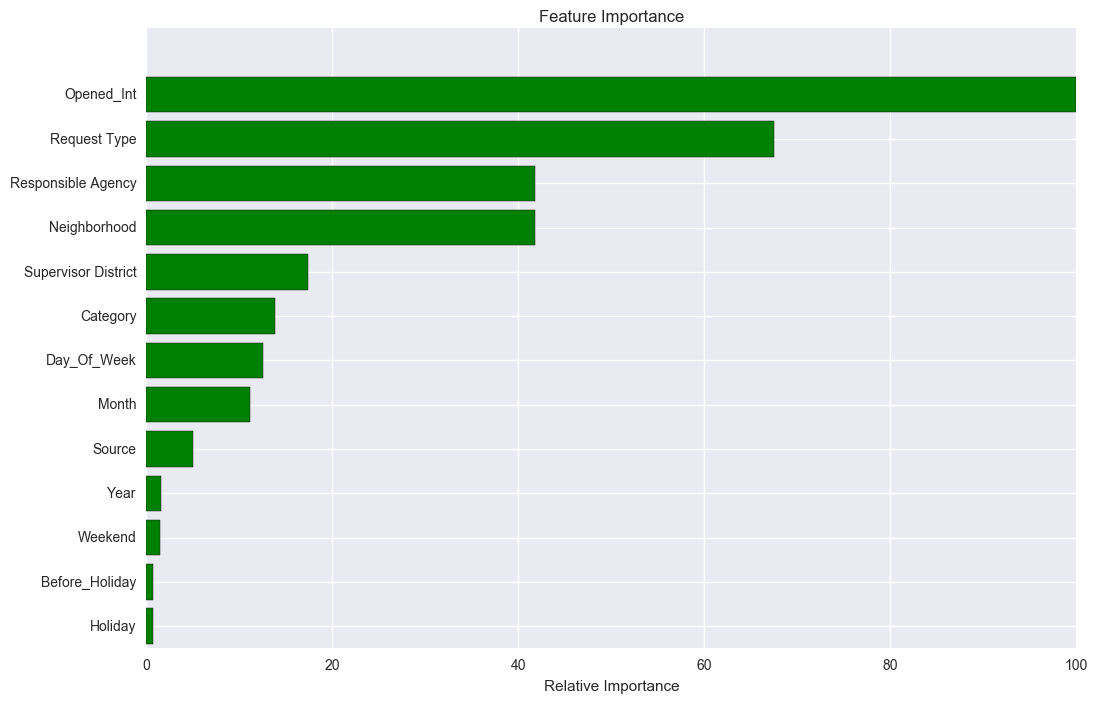

In [32]:
def plot_importance(model, X, max_features=10):
    '''Plot feature importance'''
    feature_importance = model.feature_importances_
    '''make importances relative to max importance'''
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    '''Show only top features'''
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature_names = (X.columns[sorted_idx])[-max_features:]
    
    plt.figure(figsize = (12,8))
    plt.barh(pos, feature_importance, align='center', color = 'g')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    return feature_importance

plot_importance(rfr_model, X_train, max_features=14)

RandomForestRegressor: n_estimators=100
randomF_rscore:  0.554389591679
oob_score:  0.539089620909
mse_randomF:  7770.95953615

In [38]:
'''Gradient boosting model'''
from sklearn.ensemble import GradientBoostingRegressor

'''GradientBoostingRegressor'''
def GradientBoostingRegressor_model(X_train, X_test, y_train, y_test):
    gbr = GradientBoostingRegressor(n_estimators=200, max_depth=3, subsample=1, learning_rate=0.1)
    '''other parameter:
    GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0, 
    criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
    max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, 
    alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
    '''
    gbr.fit(X_train, y_train)
    '''r_square'''
    score = gbr.score(X_test,y_test)
    yhat = gbr.predict(X_test)
    return gbr, yhat, score

gbr_model, yhat_Gboosting, Gboosting_rscore = GradientBoostingRegressor_model(X_train, X_test, y_train, y_test)
mse_Gboosting = mean_squared_error(y_test, yhat_Gboosting)

print 'Gboosting_rscore: ',Gboosting_rscore
print 'mse_Gboosting: ', mse_Gboosting

Gboosting_rscore:  0.433364475329
mse_Gboosting:  9881.50557468


GradientBoostingRegressor: n_estimators=100, learning_rate=0.1
Gboosting_rscore:  0.404093403613
mse_Gboosting:  10391.9611422

GradientBoostingRegressor: n_estimators=300, learning_rate=0.1
Gboosting_rscore:  0.449259128714
mse_Gboosting:  9604.32015444

GradientBoostingRegressor: n_estimators=600, learning_rate=0.1
Gboosting_rscore:  0.478477081498
mse_Gboosting:  9094.79092313

array([  0.00000000e+00,   0.00000000e+00,   1.82030077e-02,
         4.90939104e-02,   1.03932549e-01,   1.02663750e+00,
         1.42041112e+00,   8.86776694e+00,   2.10810456e+01,
         2.69475261e+01,   3.32083428e+01,   3.61431713e+01,
         1.00000000e+02])

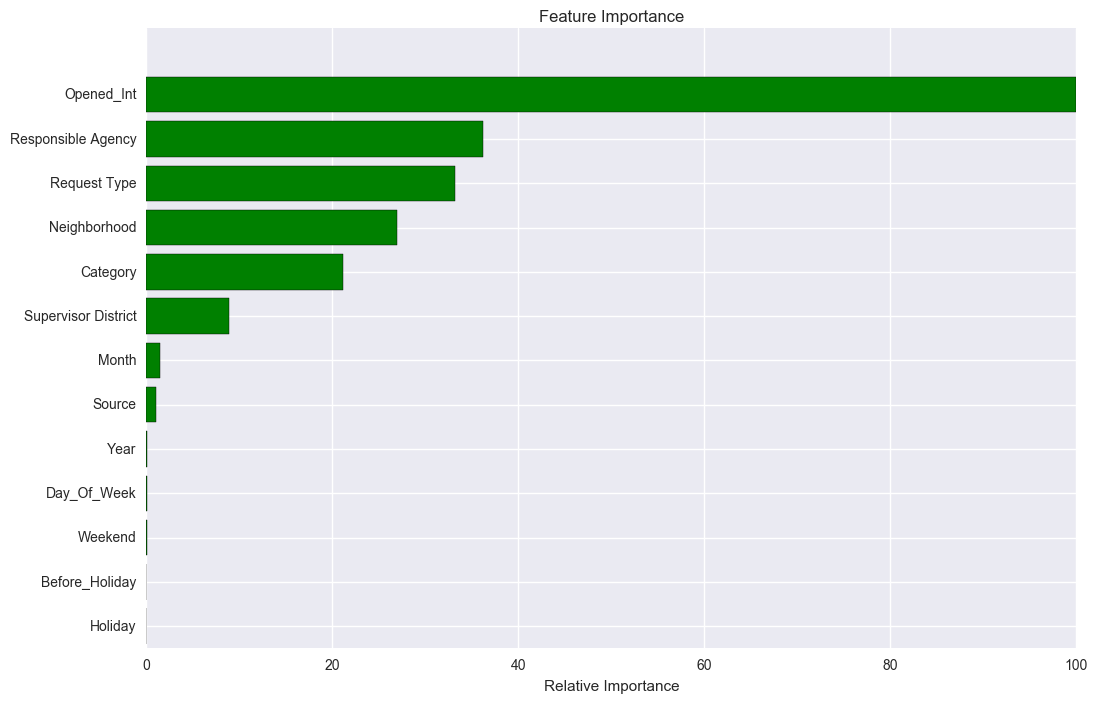

In [39]:
plot_importance(gbr_model, X_train, max_features=14)